# Fundamentals of Image and Video Processing Innovative Assignment
## Submitted by:
### 18BCE088 - Jyot Makadiya
### 18BCE259 - Shrey Viradiya

In [1]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
! mkdir Ocular
! unzip -q /content/ocular-disease-recognition-odir5k.zip -d Ocular

100% 1.62G/1.62G [00:14<00:00, 82.8MB/s]
100% 1.62G/1.62G [00:14<00:00, 121MB/s] 


# Importing Libraries

In [1]:
import numpy as np
import cv2
import os 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Enviroment variables

In [2]:
path = "/content/Ocular"
datafr = pd.read_csv(os.path.join(path, "full_df.csv"))
# Image size
ROW = 224
COL = 224

# Images file names
file_names = []

# Loaded data
training_images = []
flags = []

# Processed Features
grayscaled_images = []
inverted_images = []
thresholded_images = []
gray_histogram_of_images = []
RGB_histogram_of_images = []
conny_edged_images = []
laplacian_edged_images = []
x_edged_images = []
y_edged_images = []

threshold_mean = []
threshold_median = []
threshold_std_dev = []

conny_mean = []
conny_median = []
conny_std_dev = []

# Filtering Cataract & Healthy eyes from others

In [3]:
cutter = 0
division = 1 # Increase to decrease number of images to load .. faster outputing for testing
file_names.clear()
flags.clear()
for label, flag, file_name in zip(datafr["Left-Diagnostic Keywords"], datafr["C"], datafr["Left-Fundus"]):
    if(("cataract" in label) and (flag == 1)):
        file_names.append(file_name)
        flags.append(1)
    elif(("normal fundus" in label) and (flag == 0)):
        if(cutter%division == 0):
            file_names.append(file_name)
            flags.append(0)
        cutter = cutter + 1

cutter = 0
for label, flag, file_name in zip(datafr["Right-Diagnostic Keywords"], datafr["C"], datafr["Right-Fundus"]):
    if(("cataract" in label) and (flag == 1)):
        file_names.append(file_name)
        flags.append(1)
    elif(("normal fundus" in label) and (flag == 0)):
        if(cutter%division == 0):
            file_names.append(file_name)
            flags.append(0)
        cutter = cutter + 1

print("Data Length =",len(file_names), "files", len(flags), "flags")

Data Length = 6162 files 6162 flags


# Cataract Ratio

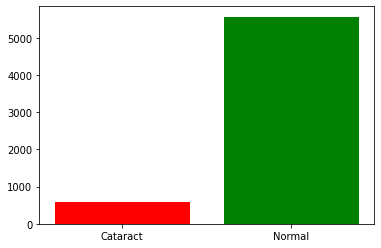

In [4]:
plt.bar([0,1], [len([i for i in flags if i == 1]), len([i for i in flags if i == 0])], color = ['r', 'g'])
plt.xticks([0, 1], ['Cataract', 'Normal'])
plt.show()

# Loading Images

In [5]:
training_images.clear()
for idx, image_name in enumerate(file_names):
    image = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (ROW, COL))
        image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype =cv2.CV_8U)
        training_images.append(image)
    except:
        del flags[idx]

In [6]:
len(training_images)

6078

# Images Sample

(6078, 224, 224, 3)
uint8


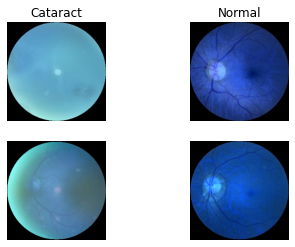

In [7]:
def showSamples(images, gray = False):
    figure, axes = plt.subplots(2, 2)
    axes[0, 0].title.set_text("Cataract")
    axes[0, 1].title.set_text("Normal")
    
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    
    axes[0, 0].imshow(images[0],cmap='gray') if gray else axes[0, 0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    axes[0, 1].imshow(images[2],cmap='gray') if gray else axes[0, 1].imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))
    axes[1, 0].imshow(images[17],cmap='gray') if gray else axes[1, 0].imshow(cv2.cvtColor(images[17], cv2.COLOR_BGR2RGB))
    axes[1, 1].imshow(images[12],cmap='gray') if gray else axes[1, 1].imshow(cv2.cvtColor(images[12], cv2.COLOR_BGR2RGB))
    plt.show()

print(np.array(training_images).shape)
print(training_images[1961].dtype)
showSamples(training_images)

# Feature Extraction

## F1 Grayscale

In [66]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.astype(np.int16)

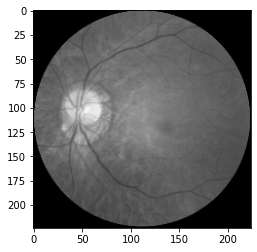

In [67]:
plt.imshow(rgb2gray(training_images[12]), cmap='gray')

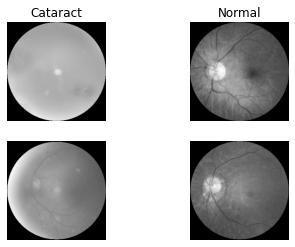

In [68]:
grayscaled_images.clear()
for idx, image in enumerate(training_images):
    gray_image = rgb2gray(image)
    grayscaled_images.append(gray_image)

showSamples(grayscaled_images, True)

## F2 Threshold

In [69]:
def THRESH_TOZERO_INV(gray):
    gray[gray > 127] = 0
    return gray

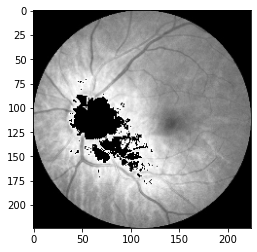

In [70]:
plt.imshow(THRESH_TOZERO_INV(grayscaled_images[2]), cmap='gray')

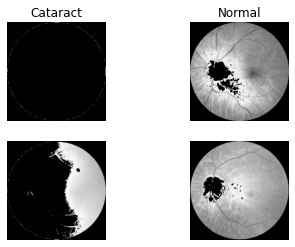

In [71]:
thresholded_images.clear()
for idx, image in enumerate(grayscaled_images):
    image = THRESH_TOZERO_INV(image)
    thresholded_images.append(image)

showSamples(thresholded_images, True)

## F4 Grayscale Histogram

In [94]:
def equalizeHist(image):
    flat = image.flatten()
    hist,bins = np.histogram(flat,256,[0,256])
    cdf = hist.cumsum()
    cdf_m = (cdf - cdf.min())*255/(cdf.max()-cdf.min())
    cdf_m = cdf_m.astype('uint8')
    img_new = cdf_m[flat]
    img_new = np.reshape(img_new, image.shape)
    return img_new

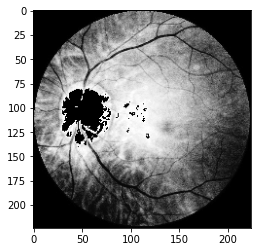

In [99]:
plt.imshow(equalizeHist(grayscaled_images[12]), cmap='gray')

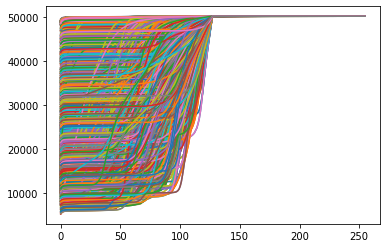

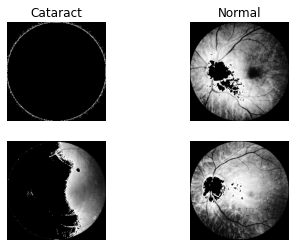

In [100]:
gray_histogram_of_images.clear()
for idx, image in enumerate(grayscaled_images):
    image_histogram = equalizeHist(image)
    gray_histogram_of_images.append(image_histogram)

showSamples(gray_histogram_of_images, True)

## F5 RGB Histogram

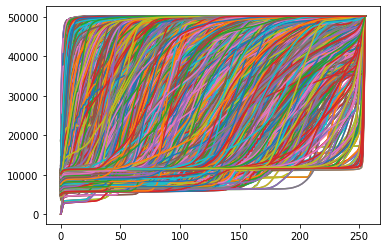

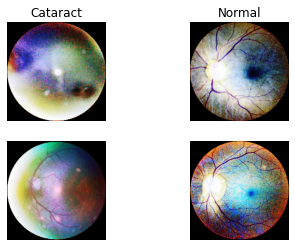

In [109]:
RGB_histogram_of_images.clear()
for idx, image in enumerate(training_images):
    image_histogram_R = equalizeHist(image[:,:,0])
    image_histogram_G = equalizeHist(image[:,:,1])
    image_histogram_B = equalizeHist(image[:,:,2])
    image_histogram = np.dstack((image_histogram_R, image_histogram_G, image_histogram_B))
    RGB_histogram_of_images.append(image_histogram)

showSamples(RGB_histogram_of_images)

## F3 Canny Edge detection

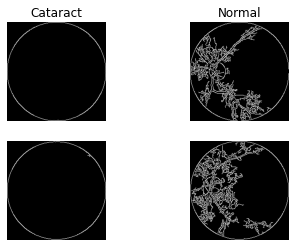

In [13]:
conny_edged_images.clear()
for idx, image in enumerate(training_images):
    image = cv2.Canny(image,30,200)
    conny_edged_images.append(image)

showSamples(conny_edged_images, True)

## F6 X Edges

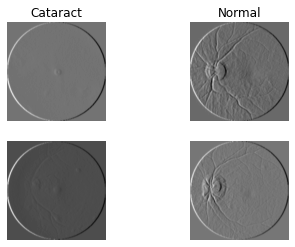

In [14]:
x_edged_images.clear()
for idx, image in enumerate(grayscaled_images):
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    x_edged_images.append(sobelx)

showSamples(x_edged_images, True)

## F7 Y Edges

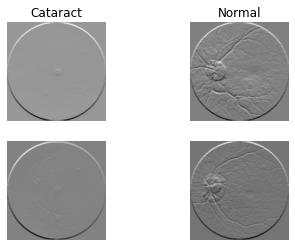

In [15]:
y_edged_images.clear()
for idx, image in enumerate(grayscaled_images):
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)  
    y_edged_images.append(sobely)

showSamples(y_edged_images, True)

## F8 Laplacian Edges

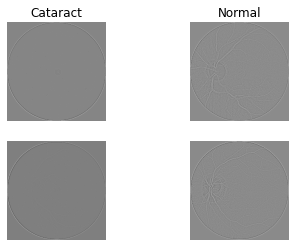

In [16]:
laplacian_edged_images.clear()
for idx, image in enumerate(grayscaled_images):
    lap_image = cv2.Laplacian(image, cv2.CV_64F)
    laplacian_edged_images.append(lap_image)

showSamples(laplacian_edged_images, True)

## F9 Mean, Median, Mode, Standard Deviation of ***Threshold***

In [17]:
threshold_mean.clear()
threshold_median.clear()
threshold_std_dev.clear()

for idx, image in enumerate(thresholded_images):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    threshold_mean.append(mean)
    threshold_median.append(median)
    threshold_std_dev.append(std_dev)

print(threshold_mean[0], threshold_mean[2])
print(threshold_median[0], threshold_median[2])
print(threshold_std_dev[0], threshold_std_dev[2])
print()
print(threshold_mean[17], threshold_mean[12])
print(threshold_median[17], threshold_median[12])
print(threshold_std_dev[17], threshold_std_dev[12])

0.39841757015306123 55.905552455357146
0.0 69.0
5.181399770957362 42.648875795341475

34.25791214923469 61.43939333545919
0.0 76.0
51.36506017581765 38.634267413853884


## F9 Mean, Median, Mode, Standard Deviation of ***Conny***

In [18]:
conny_mean.clear()
conny_median.clear()
conny_std_dev.clear()

for idx, image in enumerate(conny_edged_images):
    mean = np.mean(image)
    median = np.median(image)
    std_dev = np.std(image)
    
    conny_mean.append(mean)
    conny_median.append(median)
    conny_std_dev.append(std_dev)

print(conny_mean[0], conny_mean[2])
print(conny_median[0], conny_median[2])
print(conny_std_dev[0], conny_std_dev[2])
print()
print(conny_mean[17], conny_mean[12])
print(conny_median[17], conny_median[12])
print(conny_std_dev[17], conny_std_dev[12])

4.065688775510204 25.146285076530614
0.0 0.0
31.94089561261225 76.02609447660166

4.07585299744898 27.529795121173468
0.0 0.0
31.98014910366548 79.13411487143487


# Formating the data for Machine Learning

In [19]:
training_features = np.vstack((threshold_mean,threshold_median,threshold_std_dev,conny_mean,conny_median,conny_std_dev)).T

image_train, image_test, flag_train, flag_test = train_test_split(training_features, np.asarray(flags), test_size=0.3, random_state=1)

stdSc = StandardScaler()
image_train = stdSc.fit_transform(image_train)
image_test = stdSc.transform(image_test)

image_train = np.asarray(image_train).astype('float32')
flag_train = np.asarray(flag_train).astype('float32')

image_test = np.asarray(image_test).astype('float32')
flag_test = np.asarray(flag_test).astype('float32')

# Building, Training & Testing the NN Model

In [20]:
classifier = Sequential()

layer_info = Dense(activation='relu', input_dim=6, units=6)
classifier.add(layer_info)

layer_info = Dense(activation='relu', units=4)
classifier.add(layer_info)

layer_info = Dense(activation='sigmoid',units=1)
classifier.add(layer_info)

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier.fit(image_train, flag_train, batch_size=50, epochs=50)

flag_prediction = classifier.predict(image_test).round()

tn, fp, fn, tp = confusion_matrix(flag_test, flag_prediction).ravel()

print("True Negative =",tn)
print("False Positive =",fp)
print("False Negative =",fn)
print("True Positive =",tp)


print(confusion_matrix(flag_test, flag_prediction))
print(accuracy_score(flag_test, flag_prediction)*100)

Epoch 1/50
86/86 [==============================] - 1s 1ms/step - loss: 0.6854 - accuracy: 0.4933
Epoch 2/50
86/86 [==============================] - 0s 1ms/step - loss: 0.5490 - accuracy: 0.9049
Epoch 3/50
86/86 [==============================] - 0s 1ms/step - loss: 0.4527 - accuracy: 0.9042
Epoch 4/50
86/86 [==============================] - 0s 1ms/step - loss: 0.3520 - accuracy: 0.9127
Epoch 5/50
86/86 [==============================] - 0s 1ms/step - loss: 0.2965 - accuracy: 0.9021
Epoch 6/50
86/86 [==============================] - 0s 1ms/step - loss: 0.2502 - accuracy: 0.9045
Epoch 7/50
86/86 [==============================] - 0s 1ms/step - loss: 0.2393 - accuracy: 0.9070
Epoch 8/50
86/86 [==============================] - 0s 1ms/step - loss: 0.2243 - accuracy: 0.9062
Epoch 9/50
86/86 [==============================] - 0s 1ms/step - loss: 0.2101 - accuracy: 0.9166
Epoch 10/50
86/86 [==============================] - 0s 1ms/step - loss: 0.2200 - accuracy: 0.9040
Epoch 11/50
86/86 [